# Introduction

### Problem Description

In this presentation, some toy classification problems are studied. Their common property is that raw features to be used form inefficient representations, while a bit of feature engineering can result in guaranteed perfect scores. However, for the sake of curiosity, here features are not transformed and it is measured how well Gradient Boosting can predict class labels based on initial representations.

### Software Requirements

This notebook does not use any packages beyond a list of those that are quite popular in scientific computing. Use conda or pip to install any of them.

# General Preparations

In [1]:
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import mpl_toolkits.mplot3d.axes3d as axes3d

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Startup settings can not suppress a warning from `xgboost` and so this is needed.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import xgboost as xgb

In [2]:
np.random.seed(361)

# Concentric Spheres

This binary classification problem is very simple. There are several concentric (probably, high-dimensional) spheres and each of them is associated with one class only. This means that radius (i.e. distance between a point and the common center of all spheres) is a "golden feature" — a classifier trained only on it can achieve superior accuracy.

Nevertheless, the question is what `xgboost` is able to achieve if it is applied in a naive straightforward fashion without radius computation.

In [3]:
def draw_from_unit_sphere(sample_size, n_dim):
    """
    Draws `sample_size` random samples
    from uniform distribution on
    `n_dim`-dimensional unit sphere.
    
    The idea is to draw samples from an
    isotropic distribution (here, normal
    distribution) and then norm them.
    
    @type sample_size: int
    @type n_dim: int
    """
    normal_sample = np.random.normal(size=(sample_size, n_dim))
    radii = np.sqrt((normal_sample ** 2).sum(axis=1))
    radii = radii.reshape((radii.shape[0], 1))
    return normal_sample / radii

Let us show that the above function works.

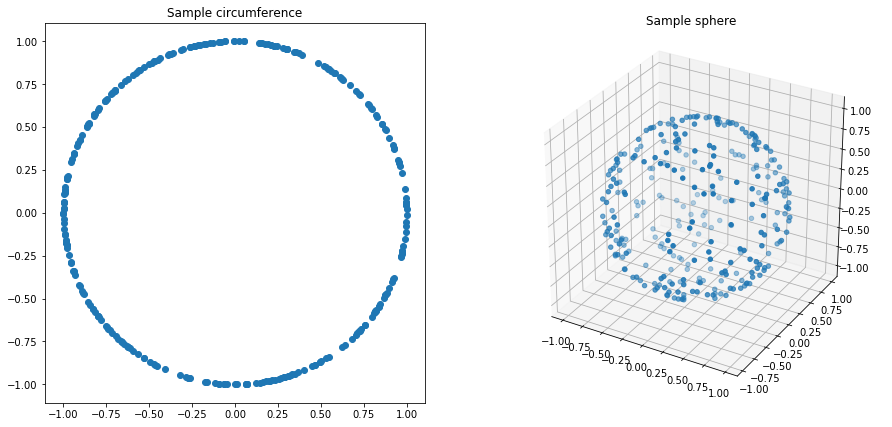

In [4]:
sample_size = 300
circumference = draw_from_unit_sphere(sample_size, 2)
three_d_sphere = draw_from_unit_sphere(sample_size, 3)

fig = plt.figure(figsize=(15, 8))

ax_one = fig.add_subplot(121)
ax_one.scatter(circumference[:, 0], circumference[:, 1])
ax_one.set_aspect('equal')
ax_one.set_title("Sample circumference")

ax_two = fig.add_subplot(122, projection='3d')
ax_two.scatter(three_d_sphere[:, 0], three_d_sphere[:, 1], three_d_sphere[:, 2])
ax_two.set_aspect('equal')
_ = ax_two.set_title("Sample sphere", y=1.075)

In [5]:
def draw_from_concentric_spheres(radii, n_dim, samples_per_sphere):
    """
    @type radii: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    """
    spheres = []
    for radius in radii:
        spheres.append(radius * draw_from_unit_sphere(samples_per_sphere, n_dim))
    spheres = np.vstack(spheres)
    return spheres

In [6]:
def synthesize_nested_spheres_dataset(radii_of_positives, radii_of_negatives,
                                      n_dim, samples_per_sphere):
    """
    Creates dataset for a binary classification
    problem, where objects are drawn from
    concentric spheres and distance from the
    origin determines the class of an object.
    
    @type radii_of_positives: list(float)
    @type radii_of_negatives: list(float)
    @type n_dim: int
    @type samples_per_sphere: int
    """
    positives = draw_from_concentric_spheres(radii_of_positives, n_dim,
                                             samples_per_sphere)
    positives = np.hstack((positives, np.ones((positives.shape[0], 1))))
    negatives = draw_from_concentric_spheres(radii_of_negatives, n_dim,
                                             samples_per_sphere)
    negatives = np.hstack((negatives, np.zeros((negatives.shape[0], 1))))
    dataset = np.vstack((positives, negatives))
    return dataset

In [7]:
def eveluate_xgboost_performance(dataset):
    """
    @type dataset: numpy.ndarray
    """
    # Prepare data.
    X_refit, X_test, y_refit, y_test = \
        train_test_split(dataset[:, :-1], dataset[:, -1],
                         stratify=dataset[:, -1], random_state=361)
    X_train, X_val, y_train, y_val = \
        train_test_split(X_refit, y_refit,
                         stratify=y_refit, random_state=361)
    dm_refit = xgb.DMatrix(X_refit, label=y_refit)
    dm_train = xgb.DMatrix(X_train, label=y_train)
    dm_val = xgb.DMatrix(X_val, label=y_val)
    dm_test = xgb.DMatrix(X_test, label=y_test)
    
    # Set hyperparameters.
    num_rounds = 3000
    hyperparams = {'max_depth': 10,  # Decision stumps work poorly here.
                   'subsample': 0.9,
                   'objective': 'binary:logistic'}
    early_stopping_rounds = 10
    learning_rates = [0.3] * 1000 + [0.2] * 1000 + [0.1] * 1000

    # Train model.
    bst = xgb.train(hyperparams, dm_train, num_rounds,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=[(dm_train, 'train'), (dm_val, 'valid')],
                    learning_rates=learning_rates,
                    verbose_eval=500)
    num_rounds = bst.best_iteration
    learning_rates = learning_rates[:num_rounds]
    bst = xgb.train(hyperparams, dm_refit, num_rounds,
                    evals=[(dm_refit, 'refit')],
                    learning_rates=learning_rates,
                    verbose_eval=500)
    
    # Evaluate performance.
    y_hat = bst.predict(dm_test)
    score = roc_auc_score(y_test, y_hat)
    return score

Settings of the experiment are introduced in the below cell. It is possible to change them in order to see what happens. 

In [8]:
positive_radii = [10, 12, 14]
negative_radii = [11, 13]

dims = [2, 3, 4, 5, 6]
base_sizes = [100, 500, 1000, 2000]
curse_adjustment_factor = 4  # Compensate curse of dimensionality.

In [9]:
scores = []
for n_dim, sample_size in product(dims, base_sizes):
    print('\n---')
    print("Dimensionality is {}, base size is {}".format(n_dim, sample_size))
    adjusted_size = (curse_adjustment_factor ** (n_dim - 1)) * sample_size
    dataset = synthesize_nested_spheres_dataset(positive_radii, negative_radii,
                                                n_dim, adjusted_size)
    score = eveluate_xgboost_performance(dataset)
    scores.append({'n_dim': n_dim, 'sample_size': sample_size, 'score': score})
    
scores_df = pd.DataFrame(scores)
scores_df


---
Dimensionality is 2, base size is 100
[0]	train-error:0.302222	valid-error:0.314667
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[29]	train-error:0.008	valid-error:0.130667

[0]	refit-error:0.285333

---
Dimensionality is 2, base size is 500
[0]	train-error:0.270578	valid-error:0.2848
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[45]	train-error:0	valid-error:0.006933

[0]	refit-error:0.286267

---
Dimensionality is 2, base size is 1000
[0]	train-error:0.252889	valid-error:0.26
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 10 rounds.
Stopping. Best iteration:
[40]	train-error:0	valid-error:0.000267

[0]	refit-error:0.262133

---
Dimensionali

,n_dim,sample_size,score
0,2,100,0.951883
1,2,500,0.999986
2,2,1000,1.000000
3,2,2000,0.999999
4,3,100,0.791895
5,3,500,0.976134
6,3,1000,0.995702
7,3,2000,0.999845
8,4,100,0.689004
9,4,500,0.878398


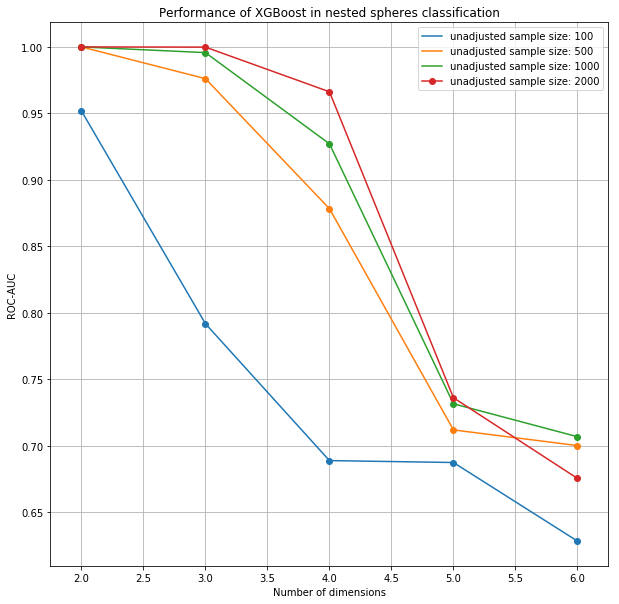

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for idx, group in scores_df.groupby(['sample_size']):
    name_for_legend = 'unadjusted sample size: {}'.format(idx)
    group[name_for_legend] = group['score']
    group.plot('n_dim', name_for_legend, ax=ax, marker='o')
ax.set_xlim(min(dims) - 0.25, max(dims) + 0.25)
ax.grid(True)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('ROC-AUC')
_ = ax.set_title('Performance of XGBoost in nested spheres classification')

To be continued.